#### 2021-04-14 Extinction and colors ##

**2021-04-14:** lots of hacks to tune this for bulge figures of merit. To avoid version confusion on the repository, I am splitting this into a new notebook.

Started 2021-04-12 to try an approximation for the color precision. This particular case investigates the distance to photometric precision (or crowding error - whichever is closer) for a red clump giant star. For the example below, an object must be measured at 0.1 (0.15) mag precision in both of u (i) to be considered well-enough measured to use the (u-i) - [Fe/H] calibration in Johnson et al. 2020 (expression 22).

**2021-04-13:** updates: 

 * region of interest defined for being in the "bulge"
 * now computes the figure of merit: the total volume within the bulge region of interest
 * converts the results to astropy table and outputs the table of figure of merit per run
 * plots a summary figure comparing the runs.

In [1]:
# where are we?
import os
print(os.getcwd())

/home/jail/dlusers/wiclarks/testNotebooks


In [2]:
%matplotlib inline
# some standard pieces
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import os, glob # for checking existence of db

In [3]:
# set up for lsst
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
import lsst.sims.maf.maps as maps
# need a different set of utils for the stellarmags
import lsst.sims.utils as sims_utils



/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/db/opsimDatabase.py:95: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if groupBy is 'default' and tableName==self.defaultTable:
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/db/opsimDatabase.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if groupBy is 'default' and tableName!=self.defaultTable:
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/slicers/opsimFieldSlicer.py:127: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  (key is not 'bins') & (key is not 'binCol'):
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/slicers/opsimFieldSlicer.py:127: SyntaxWarning: "is not" with a literal. Did yo

In [87]:
# Ensure the reddening utilities are locally available. For this prototype I just symlink
# them from my local copy of github repository https://github.com/willclarkson/rubinCadenceScratchWIC
import readExtinction
pathReddening = 'merged_ebv3d_nside64_defaults.fits'
print(pathReddening, os.access(pathReddening, os.R_OK))

merged_ebv3d_nside64_defaults.fits True


### Set up the metrics we want from MAF ###

In [88]:
def getBundles(pathOpsim='', sFilter='u', goalUncty=0.25, nside=64, \
                  nightMax=10000, doPlots=False, run_name='', outDir='color_test'):
    
    """Evaluates a metric bundle for m5sigma and crowding uncertainty for the specified filter"""
    
    if len(pathOpsim) < 1:
        return None
    
    if not os.access(pathOpsim, os.R_OK):
        return None
    
    # if a run name was not supplied, make one up by parsing the path to the opsim
    if len(run_name) < 1:
        run_name = pathOpsim.split('/')[-1]   
        
        # we DO want the _v because it separates the baselines from each other.
        #.split('_v')[0]
            
    bundleList = []
    sql = 'filter="%s" and night < %i' % (sFilter, nightMax)
    slicer = slicers.HealpixSlicer(nside=nside, useCache=False) # useCache for working with maps
    plotFuncs = [plots.HealpixSkyMap(), plots.HealpixHistogram()]
    plotDict = {}
    resultsDb = db.ResultsDb(outDir=outDir)
    summaryStats = [metrics.MedianMetric()]
    
    metricM5 = metrics.Coaddm5Metric('fiveSigmaDepth')
    bundleList.append(metricBundles.MetricBundle(metricM5,slicer,sql,
                                                 plotDict=plotDict, plotFuncs=plotFuncs,
                                                 runName=run_name,
                                                 summaryMetrics=summaryStats))
    
    # Compute the m5 crowding uncertainty at requested crowding uncertainty and at given filter
    mapsList = [maps.TrilegalDensityMap(filtername=sFilter, nside=nside)]
    metricCrowd = metrics.CrowdingM5Metric(goalUncty, sFilter, maps=[])
    bundleList.append(metricBundles.MetricBundle(metricCrowd,slicer,sql,
                                                 plotDict=plotDict, plotFuncs=plotFuncs,
                                                 runName=run_name,
                                                 mapsList=mapsList,
                                                 summaryMetrics=summaryStats))
    
    # 2021-04-13 6pm: we can do the counts at precision <= some number here too. 
    # Use sql to select points by depth and then use the CountMetric to count them.
    #
    # Perhaps make this an option if we don't need this for [u,i]??
    
    
    # actually run things
    conn = db.OpsimDatabase(pathOpsim)
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    
    if doPlots:
        bg.plotAll(closefigs=False)
    
    # returns the bundlegroup for this filter
    return bg
    

### Set paths to opsims ###

In [89]:
# paths to opsims
lBaseline = glob.glob('/sims_maf/fbs_1.7/baseline/*db')
lUheavy = glob.glob('/sims_maf/fbs_1.7/u_long/*50*db')

lPaths = [lBaseline[-1]] + lUheavy  # for testing

# Here is a more comprehensive list for running on a few opsims:
lFootprint = ['/sims_maf/fbs_1.7/footprint_tune/footprint_6_v1.710yrs.db', \
              '/sims_maf/fbs_1.7/footprint_tune/footprint_8_v1.710yrs.db']
#lDust = ['/sims_maf/fbs_1.7.1/new_rolling/bulge_roll_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db']
# lBulge = ['/sims_maf/fbs_1.5/bulge/bulges_i_heavy_v1.5_10yrs.db']
lBulge = glob.glob('/sims_maf/fbs_1.5/bulge/bu*.db')
lSeeing = ['/sims_maf/fbs_1.5/goodseeing/goodseeing_gi_v1.5_10yrs.db']
lFilterDist = glob.glob('/sims_maf/fbs_1.5/filter_dist/filterdist_indx?_v1.5_10yrs.db')
#lRolling = ['/sims_maf/fbs_1.7.1/new_rolling/bulge_roll_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db']
lSmooth = ['/sims_maf/fbs_1.5/footprints/footprint_gp_smoothv1.5_10yrs.db']

# 1.7.1 use a different baseline. So we make a separate list...
lRolling = glob.glob('/sims_maf/fbs_1.7.1/new_rolling/*db')



lBaseline1p5 = ['/sims_maf/fbs_1.5/baseline/baseline_v1.5_10yrs.db']

# We arrange these into v1.5 and v1.7 comparisons. We work out how to add the 
# divider into the figure later.
l1p7 = lBaseline[::-1] + lFootprint + lUheavy
l1p71 = lRolling
l1p5 = lBaseline1p5 + lBulge + lSeeing + lFilterDist + lSmooth

# uncomment this line if you want to run on a more extensive set of runs
# lPaths = lBaseline + lUheavy + lFootprint + lDust + lBulge + lSeeing + lFilterDist + lRolling + lSmooth

lPaths = l1p7 + l1p71 + l1p5

print(lPaths)
# print(l1p71)

print(len(lPaths))

['/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs.db', '/sims_maf/fbs_1.7/baseline/baseline_nexp1_v1.7_10yrs.db', '/sims_maf/fbs_1.7/footprint_tune/footprint_6_v1.710yrs.db', '/sims_maf/fbs_1.7/footprint_tune/footprint_8_v1.710yrs.db', '/sims_maf/fbs_1.7/u_long/u_long_ms_50_v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/baseline_nexp2_v1.7.1_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/bulge_roll_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/bulge_roll_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/footprint_6_v1.7.1_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/full_disk_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/full_disk_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/full_disk_v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/rolling_nm_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db', '/sims_maf/fbs_1.7.1/new_rolling/rolling_nm_scale0.90_nslice3_f

### import the E(B-V) map ###

In [90]:
#from importlib import reload
#reload(readExtinction)
ebv = readExtinction.ebv3d(pathReddening)
ebv.loadMap()

In [91]:
os.access('/sims_maf/fbs_1.5/filter_dist/filterdist_indx?_v1.5_10yrs.db', os.R_OK)

False

### Set up the target object absolute magnitudes ###

In [92]:
# Approximate a Red Clump giant at r-band absolute mag 0.55
absMags = sims_utils.stellarMags('K', 0.55)

### Now loop through the opsims and filters ###

In [93]:
# now try looping through our filters
lFilters = ['u', 'i']
lUnctys = [0.1, 0.15] # let's be optimistic... this would give sigma(u-i) ~ 0.18 --> sigma(Fe/H) << 0.2
runEvals = {}
nside=64
# goalUncty = 0.25
nightMax=1e4
doPlots = False # the magnitude limits are informative
for pathOpsim in lPaths:
    
    # dictionary to hold results
    bundlesResults = {}
    runName = ''
    for sFilter, goalUncty in zip(lFilters, lUnctys):
        
        # Find m5sigma and crowding uncertainty in this filter
        bgroup = getBundles(pathOpsim, sFilter, goalUncty, nside, nightMax, doPlots)
        
        # Estimate delta mag taking m5sigma to magnitude at goal uncertainty
        deltamag = -5.0*np.log10(0.2/goalUncty)
        
        # Construct the dictionary of results lifted from this bundle group
        bundlesResults[sFilter] = {}
        
        bundlesResults[sFilter]['deltamag'] = deltamag
        bundlesResults[sFilter]['goalUncty'] = goalUncty
        
        for key in bgroup.bundleDict.keys():
            
            # ensure the run name is populated
            runName = bgroup.bundleDict[key].runName
            bundlesResults[sFilter]['runName'] = runName
            
            if key.find('CoaddM5') > -1:
        
                # Add the magnitude offset onto the metric values and store
                depths = bgroup.bundleDict[key].metricValues + deltamag
                bundlesResults[sFilter]['mPhot'] = depths
                
            if key.find('Crowding') > -1:
                crowds = bgroup.bundleDict[key].metricValues
                bundlesResults[sFilter]['mCrowd'] = crowds
        
        # Use the extinction map to estimate at what distance these magnitudes are encountered
        M_abs = absMags[sFilter]
        dists_phot, _, _  = ebv.getDistanceAtMag(depths - M_abs, sFilter)
        dists_crowd, _, _ = ebv.getDistanceAtMag(crowds - M_abs, sFilter)
        
        # For diagnostic purposes, we send both sets of distances to the results dictionary
        bundlesResults[sFilter]['pc_phot'] = dists_phot
        bundlesResults[sFilter]['pc_crowd'] = dists_crowd
                        
    # append this onto the list of evaluations
    if len(runName) > 0:
        runEvals[runName] = bundlesResults
        

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="u" and night < 10000 for columns ['fieldRA', 'fiveSigmaDepth', 'seeingFwhmGeom', 'fieldDec']
Found 130925 visits
Running:  ['baseline_nexp2_v1_7_10yrs_db_CoaddM5_u_and_night_lt_10000_HEAL', 'baseline_nexp2_v1_7_10yrs_db_Crowding_to_Precision_0_10_u_and_night_lt_10000_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="i" and night < 10000 for columns ['fieldRA', 'fiveSigmaDepth', 'seeingFwhmGeom', 'fieldDec']
Found 455743 visits
Running:  ['baseline_nexp2_v1_7_10yrs_db_CoaddM5_i_and_night_lt_10000_HEAL', 'baseline_nexp2_v1_7_10yrs_db_Crowding_to_Precision_0_15_i_and_night_lt_10000_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [94]:
# now that we've done all that, let's take a look at some of the results. We use
# ebv.showMollview() to use the fontsize-handling capabilities for the colorbar.

# To keep things flexible, we build titles programmatically:
#runname = 'u_long_ms_50'
runname = 'baseline_nexp2'
results = runEvals[runname]
sfilt = 'i'
targUncty = results[sfilt]['goalUncty']

# max distance to show
maxPc = 20000

# just for info, print the delta mag we estimated
print(results[sfilt]['deltamag'])

figU1 = ebv.showMollview(results[sfilt]['pc_phot'], 1, fontsize=8, sUnit='pc', \
                         sTitle='%s: Distance to phot depth at %.2f (%s), pc' % (runname, targUncty, sfilt), \
                        maxval=maxPc, cmap='Set2_r')
figU2 = ebv.showMollview(results[sfilt]['pc_crowd'], 2, fontsize=8, sUnit='pc', \
                         sTitle='%s: Distance to crowding at %.2f (%s), pc' % (runname, targUncty, sfilt), \
                        maxval=maxPc, cmap='Set2_r')


KeyError: 'baseline_nexp2'

In [95]:
# Or - and this is probably the metric - we find the minimum distance 
# across the types (crowding or phot) and filters (u or i). We can do this on the dictionary
# of intermediate results:
print(runEvals.keys())

dict_keys(['baseline_nexp2_v1.7_10yrs.db', 'baseline_nexp1_v1.7_10yrs.db', 'footprint_6_v1.710yrs.db', 'footprint_8_v1.710yrs.db', 'u_long_ms_50_v1.7_10yrs.db', 'baseline_nexp2_v1.7.1_10yrs.db', 'bulge_roll_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db', 'bulge_roll_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db', 'footprint_6_v1.7.1_10yrs.db', 'full_disk_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db', 'full_disk_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db', 'full_disk_v1.7_10yrs.db', 'rolling_nm_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db', 'rolling_nm_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db', 'six_stripe_scale0.90_nslice6_fpw0.9_nrw0.0v1.7_10yrs.db', 'baseline_v1.5_10yrs.db', 'bulges_bs_v1.5_10yrs.db', 'bulges_bulge_wfd_v1.5_10yrs.db', 'bulges_cadence_bs_v1.5_10yrs.db', 'bulges_cadence_bulge_wfd_v1.5_10yrs.db', 'bulges_cadence_i_heavy_v1.5_10yrs.db', 'bulges_i_heavy_v1.5_10yrs.db', 'goodseeing_gi_v1.5_10yrs.db', 'filterdist_indx1_v1.5_10yrs.db', 'filterdist_indx2_v1.5_10yrs.db', '

In [96]:
def getMinimumDistances(results={}):
    
    """Returns the skymap of minimum distances to the photometric or crowding uncertainty,
    across the filters. Requires a results dictionary with entries set up by filter and by 
    computed distance. For example, the 'u' entry would look like:
    
    results['u']['pc_phot'] = [masked array of healpix values]
    
    results['u']['pc_crowd'] = [masked array of healpix values]
    
    """
    
    if len(results.keys()) < 1:
        return None
    
    # 2021-04-12 I think the best way to set this up is to stack all the distances into 
    # a 2D array and find the minimum along the non-healpix axis. That would allow us 
    # to learn which filter (and which quantity) was the minimum, if we so desired. So:
    dists = np.array([])
    
    for filt in results.keys():
        for key in ['pc_phot', 'pc_crowd']:
            
            # handle non-filter entries in this dictionary
            
            try:
                thisDist = results[filt][key]
            except:
                continue 
                
            if np.size(dists) < 1:
                dists = np.copy(thisDist)
            else:
                dists = np.vstack(( dists, thisDist ))
    
    return np.min(dists, axis=0)


In [97]:
# To evaluate a figure of merit, we select healpix within a field of view of interest and 
# add up the volume encompassed. Most of the effort here is in the spatial selection. So:
from astropy.coordinates import SkyCoord
import astropy.units as u

# Assign each healpix a Galactic coordinate...
ipix = np.arange(hp.nside2npix(nside))
ra, dec = hp.pix2ang(nside, ipix, nest=False, lonlat=True)
coo = SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')
l = coo.galactic.l.deg
b = coo.galactic.b.deg
l[l > 180.] -= 360.

# ... and set a boolean by region
bROI = np.repeat(False, np.size(l))

# Let's try the zone of avoidance from maf's "_plot_mwZone" as a starting
# point, with approximate disk and bulge cutoff regions included.
peakWidth=np.radians(8.)
taperLength=np.radians(80.)
diskThickDeg = 5.
lBulgeMin = -20
lBulgeMax = 20


val = peakWidth * np.cos(np.radians(l) / taperLength * np.pi / 2.)
inBulge = (np.abs(np.radians(b)) <= val)
inDisk = (np.abs(b) < diskThickDeg) & (np.abs(np.radians(l)) < taperLength)
inLongitude = (l > lBulgeMin) & (l < lBulgeMax)

inROI = (inBulge) | (inDisk)
inROI = (inROI) & (inLongitude)


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/pyth

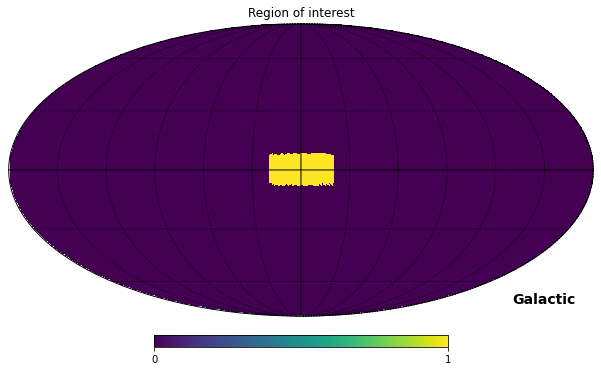

In [98]:
hp.mollview(inROI, coord=['C', 'G'], title='Region of interest')
hp.graticule()

## Compute the Figure of Merit: volume with simultaneous precision in all the filters ##

In [99]:
# now we've defined this, let's set up a sky-map for the closest distance at which the minimum
# uncertainty condition was met for all filters simultaneously. We can loop through the run names 
# in order to attach this sky map to each of the run names we've tried...
pixareaSquareRadians = hp.nside2pixarea(nside, degrees=False)
for runname in runEvals.keys():
    minDist = getMinimumDistances(runEvals[runname])
    runEvals[runname]['pc_min'] = minDist
    
    # and find the volume for this sensitivity. THIS IS THE FIGURE OF MERIT.
    runEvals[runname]['volume'] = np.sum(minDist[inROI]**3) * pixareaSquareRadians
    print("INFO: %s, %.2e" % (runname, runEvals[runname]['volume']))

INFO: baseline_nexp2_v1.7_10yrs.db, 2.69e+11
INFO: baseline_nexp1_v1.7_10yrs.db, 2.70e+11
INFO: footprint_6_v1.710yrs.db, 3.25e+11
INFO: footprint_8_v1.710yrs.db, 2.86e+11
INFO: u_long_ms_50_v1.7_10yrs.db, 3.18e+11
INFO: baseline_nexp2_v1.7.1_10yrs.db, 2.63e+11
INFO: bulge_roll_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db, 3.07e+11
INFO: bulge_roll_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db, 3.28e+11
INFO: footprint_6_v1.7.1_10yrs.db, 2.96e+11
INFO: full_disk_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db, 3.38e+11
INFO: full_disk_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db, 3.08e+11
INFO: full_disk_v1.7_10yrs.db, 3.47e+11
INFO: rolling_nm_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db, 2.73e+11
INFO: rolling_nm_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db, 3.06e+11
INFO: six_stripe_scale0.90_nslice6_fpw0.9_nrw0.0v1.7_10yrs.db, 3.17e+11
INFO: baseline_v1.5_10yrs.db, 2.97e+11
INFO: bulges_bs_v1.5_10yrs.db, 2.64e+11
INFO: bulges_bulge_wfd_v1.5_10yrs.db, 3.10e+11
INFO: bulges_cadence_bs_v1

In [104]:
# Convert to astropy table and write to disk
runnames = []
foms = []
for runname in runEvals.keys():
    
    foms.append(runEvals[runname]['volume'])
    
    # make a shortened runname version
    runnameShort = '_'.join(runname.split('_')[0:4]).split('.db')[0]
    runnames.append(runnameShort)
    
# Now convert this into an astropy table
from astropy.table import Table # if needed
tFoms = Table()
tFoms['runnames'] = runnames
tFoms['fom'] = np.array(foms)
tFoms['fom'].unit=u.pc**3

# add metadata...
tFoms.meta['lFilters'] = lFilters
tFoms.meta['lUnctys'] = lUnctys
tFoms.meta['whichFom'] = 'Simultaneous precision in %s' % (','.join(lFilters))

# ... and write to disk
tFoms.write('test_FoM_precis.fits', overwrite=True)

### Summary figure ###

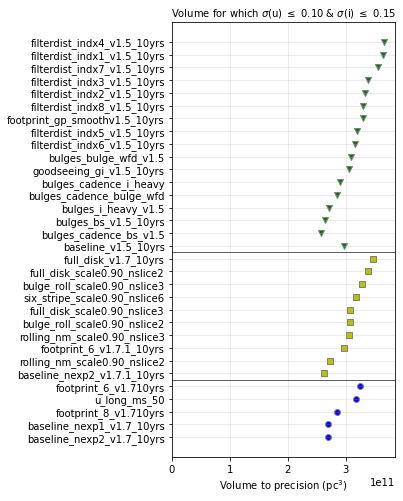

In [174]:
# OK now we have our figures of merit. Let's try plotting them as per Peter's Lots_of_runs.ipynb, 
# with a few tweaks. There's probably a way to make this more pythonic: I just copied and pasted
# the same code with arguments reversed for the moment...

# Sort each group by figure of merit value?
sortByFom = True

# Orientation of the plot
namesAcrossBottom = False

# lower axis at zero? (Set to 0 to use 0, or None to use the autoscale
# lowerLim = None
lowerLim = 0.

figsize = [8,4]
if not namesAcrossBottom:
    figsize = figsize[::-1]

    
fig1 = plt.figure(1, figsize=figsize)
ax1 = fig1.add_subplot(111)
x = np.arange(len(runnames))

fig1.set_size_inches(figsize[0], figsize[1], forward=True)

# Format handles
from matplotlib.ticker import ScalarFormatter
c_formatter = ScalarFormatter(useOffset=False)

# Partition into groups by baseline
x1p7  = x[len(l1p7)]-0.5
x1p71 = x1p7 + len(l1p71) 

# I think the best way to handle this is to treat the 
# three branches as separate arrays so we can argsort 
# and plot separately. So:
b1p7 = x < x1p7
b1p71 = (x > x1p7) & (x < x1p71)
b1p5 = (x > x1p71)

# we turn these into lists we can iterate through:
lSets = [b1p7, b1p71, b1p5]
syms = ['o', 's', 'v']
colos = ['b', 'y', 'g']
fomsA = np.array(foms)

# We need to ensure the run names are also constructed in order. This is a 
# little awkward. We create a numpy array to hold the names, and construct
# it piece by piece as with the figures of merit.
runnamesA = np.array(runnames)
runnamesSho = np.array([])

for iSet in range(len(lSets)):
    bThis = lSets[iSet]
    
    # are we sorting by fom value?
    if not sortByFom:
        if namesAcrossBottom:
            dum = ax1.scatter(x[bThis], fomsA[bThis], edgecolor='0.5', marker=syms[iSet], c=colos[iSet])
        else:
            dum = ax1.scatter(fomsA[bThis], x[bThis], edgecolor='0.5', marker=syms[iSet], c=colos[iSet])
        runnamesSho = np.hstack((runnamesSho, runnamesA[bThis] ))
        continue
        
    # otherwise, sort by figure of merit.
    xThis = np.copy(x[bThis])
    fThis = np.copy(fomsA[bThis])
    nThis = np.copy(runnamesA[bThis])
    
    lSort = np.argsort(fThis[1::])
    fSho = np.hstack(( fThis[0], fThis[1::][lSort]))
    runnamesSho = np.hstack((runnamesSho, nThis[0], nThis[1::][lSort]))
    
    if namesAcrossBottom:
        dum = ax1.scatter(xThis, fSho, edgecolor='0.5', marker=syms[iSet], color=colos[iSet])
    else:
        dum = ax1.scatter(fSho, xThis, edgecolor='0.5', marker=syms[iSet], color=colos[iSet])
        
    
# construct condition string for the title
sTitle = r'Volume for which'
for sfilt, precis in zip(lFilters, lUnctys):
    sTitle = r'%s $\sigma$(%s) $\leq$ %.2f &' % (sTitle, sfilt, precis)
sTitle = sTitle[0:-1]
ax1.set_title(sTitle, fontsize=10)  # conditions label from above

# let's set the suptitle so that the string will fit across the figure
# fig1.suptitle(sTitle, fontsize=11)  # conditions label from above


#dum = ax1.scatter(x, foms, edgecolor='0.5', zorder=2)

if namesAcrossBottom:
    ax1.yaxis.set_major_formatter(c_formatter)
    ax1.set_ylabel(r'Volume to precision (pc$^3$)')
    ack = plt.xticks(x, runnamesSho, rotation=90)

    for xDivide in [x1p7, x1p71]:
        blah = ax1.axvline(xDivide, color='0.5', ls='-', alpha=0.7)

    #ax1.set_ylim(bottom=0., top=np.max(foms)*1.05)
    ax1.set_ylim(top=np.max(foms)*1.05)

else:
    
    ax1.xaxis.set_major_formatter(c_formatter)
    ax1.set_xlabel(r'Volume to precision (pc$^3$)')
    ack = plt.yticks(x, runnamesSho, rotation=0)

    for xDivide in [x1p7, x1p71]:
        blah = ax1.axhline(xDivide, color='0.3', ls='-', alpha=0.9, lw=1)

    #ax1.set_xlim(left=0., right=np.max(foms)*1.05)
    ax1.set_xlim(lowerLim, np.max(foms)*1.05)
    #ax1.set_xlim(right=np.max(foms)*1.05)
    
dum2 = ax1.grid(which='both', alpha=0.3, zorder=1)

# save the figure
fig1.savefig('fom_u_minus_i.png')

### Debug figures - sky maps of the minimum distances ###

/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Set2_r").copy()
  newcm.set_over(newcm(1.0))
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Set2_r").copy()
  newcm.set_under(bgcolor)
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python

(0.5, -1.0)


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 20 deg 0.00'.
  warnings.warn(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 20 deg 0.00'.
  warnings.warn(


(0.5, -1.0)


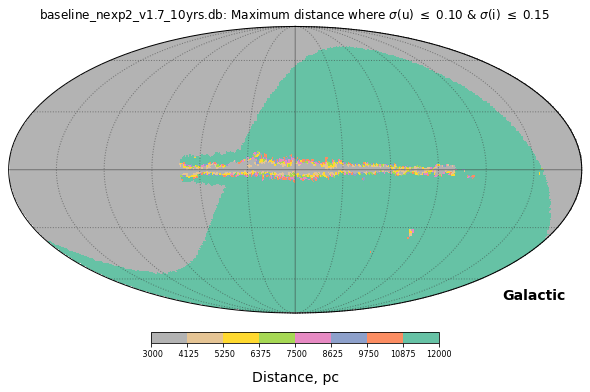

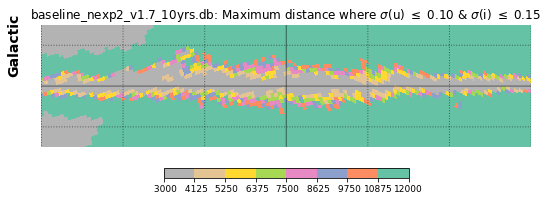

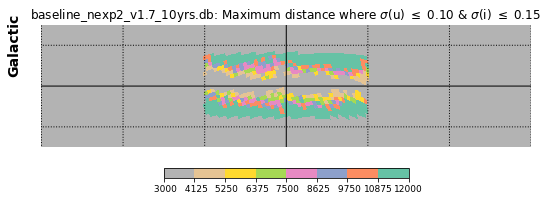

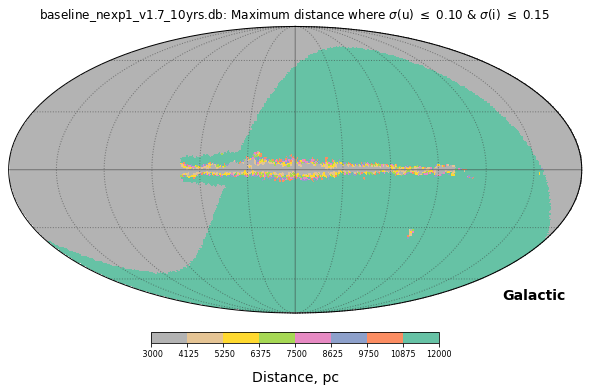

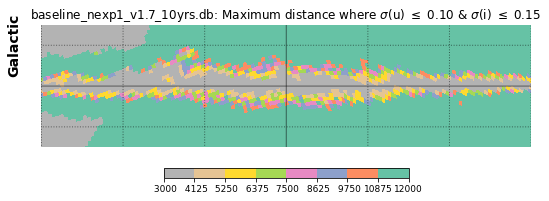

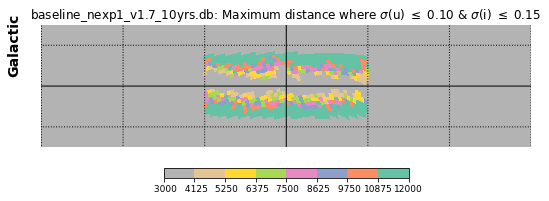

In [102]:
# now that we've populated this, we can show the results. Construct a title out of the 
# filters and uncertainties we asked for:

# (Getting the first key in the dictionary is not really trivial)
fignum = 2
for runKey in list(runEvals.keys())[0:2]:
    thisRun = runEvals[runKey]
    run_name = thisRun[list(thisRun.keys())[0]]['runName']

    sTitle = r'%s: Maximum distance where' % (run_name)
    for sfilt, precis in zip(lFilters, lUnctys):
       sTitle = r'%s $\sigma$(%s) $\leq$ %.2f &' % (sTitle, sfilt, precis)
    sTitle = sTitle[0:-1]

    # try incorporating our region of interest...
    vecSho = np.ma.masked_less_equal(runEvals[runKey]['pc_min'], 0.)
    # vecSho.mask = (vecSho.mask) | (~inROI)

    minval = 3000
    maxval = 12000
    
    # Try showing a view
    #fig3 = ebv.showMollview(runEvals[runKey]['pc_min'], fignum, fontsize=8, sTitle=sTitle, \
    #                       sUnit='Distance, pc', maxval=15000, cmap='Set2_r')
    
    fig3 = ebv.showMollview(vecSho, fignum, fontsize=8, sTitle=sTitle, \
                           sUnit='Distance, pc', minval=minval, maxval=maxval, cmap='Set2_r')

    

    # Try zooming in with cartview
    plt.figure(fignum+1).clf()
    hp.cartview(runEvals[runKey]['pc_min'],fignum+1, coord=['C','G'], max=maxval, latra=[-15,15], \
              lonra=[-60,60], title=sTitle, cmap='Set2_r', min=minval)

    hp.delgraticules()
    hp.graticule(dpar=5, dmer=5,  alpha=0.5)
       
    # import Alessandro's method for handling the ticks
    labelsize=9
    nTicks = 9
    cbar =  plt.gca().images[-1].colorbar
    cmin, cmax = cbar.mappable.get_clim()
    cmap_ticks = np.linspace(cmin, cmax, num=nTicks)
    cbar.set_ticks(cmap_ticks, True)
    cmap_labels = ["{:5.0f}".format(t) for t in cmap_ticks]
    cbar.set_ticklabels(cmap_labels)
    cbar.ax.tick_params(labelsize=labelsize) 

    plt.figure(fignum+1).set_size_inches(8,4, forward=True)
    
    # test that our ROI is sensible
    plt.figure(fignum+2).clf()
    hp.cartview(vecSho*inROI,fignum+2, coord=['C','G'], latra=[-15,15], \
              lonra=[-60,60], title=sTitle, cmap='Set2_r', max=maxval, min=minval)

    # import Alessandro's method for handling the ticks
    labelsize=9
    nTicks = 9
    cbar =  plt.gca().images[-1].colorbar
    cmin, cmax = cbar.mappable.get_clim()
    cmap_ticks = np.linspace(cmin, cmax, num=nTicks)
    cbar.set_ticks(cmap_ticks, True)
    cmap_labels = ["{:5.0f}".format(t) for t in cmap_ticks]
    cbar.set_ticklabels(cmap_labels)
    cbar.ax.tick_params(labelsize=labelsize) 

    
    hp.graticule(dpar=5, dmer=5)
    plt.figure(fignum+2).set_size_inches(8,4, forward=True)

    
    fignum += 3